In [1]:
from catchit import CatchItEnvOneStep, CatchItEnvRender
import numpy as np
np.bool8 = np.bool_
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt

In [2]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [3]:
# Hyperparameters
BATCH_SIZE = 128 
GAMMA = 0.99           
EPSILON_MIN = 0.05     
EPSILON_DECAY = 0.9965
LEARNING_RATE = 0.0005 
TARGET_UPDATE = 20     
MEMORY_SIZE = 50000

In [4]:
# env = CatchItEnv(render_mode='human')  # Catch It environment
env = CatchItEnvOneStep()  # Catch It environment
state_size = env.observation_space.shape[0]  
action_size = env.action_space.n             

# Initialize networks
policy_net = DQN(state_size, action_size)  # Main Q-network
target_net = DQN(state_size, action_size)  # Target Q-network
target_net.load_state_dict(policy_net.state_dict())  # Sync weights

optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)  # Optimizer
memory = deque(maxlen=MEMORY_SIZE)  # Replay buffer (stores past experiences)

In [6]:
def select_action(state, epsilon):
    if random.random() < epsilon:  # Explore: random action
        return env.action_space.sample()
    else:  # Exploit: best action from policy_net
        with torch.no_grad():
            return policy_net(state).argmax().item()

In [7]:
def remember(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))

In [8]:
def train():
    if len(memory) < 2000:  # Wait until enough samples
        return

    # Sample a mini-batch from memory
    batch = random.sample(memory, BATCH_SIZE)
    states, actions, rewards, next_states, dones = zip(*batch)

    # Convert to PyTorch tensors
    states = torch.FloatTensor(np.array(states))
    actions = torch.LongTensor(actions)
    rewards = torch.FloatTensor(rewards)
    next_states = torch.FloatTensor(np.array(next_states))
    dones = torch.FloatTensor(dones)

    # Compute current Q-values (from policy_net)
    current_q = policy_net(states).gather(1, actions.unsqueeze(1))  # [128, 1]

    # Compute target Q-values (from target_net)
    next_q = target_net(next_states).max(1)[0].detach()             # [128]
    target_q = rewards + (GAMMA * next_q * (1 - dones))             # [128]

    # Compute loss (MSE)
    # ✅ Fix shape mismatch by squeezing current_q
    loss = F.mse_loss(current_q.squeeze(), target_q)
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [21]:
# env = CatchItEnv(render_mode='human')  # Catch It environment
EPSILON = 0.5
EPISODES = 400

In [22]:
scores = []  # Track episode rewards
caught = 0
for episode in range(EPISODES):
    state = env.reset()[0]
    state = torch.FloatTensor(state)
    total_reward = 0
    no_actions = 0
    while True:
        # Select & execute action
        # Smart escape if stuck and exploration is low

        # if EPSILON <= 0.55:
        action = select_action(state, EPSILON)
        # else:
        #     action = select_action_guided(state, EPSILON)

        next_state, reward, terminated, truncated, _ = env.step(action)  # Unpack 5 values
        done = terminated  # Handle both termination conditions
        next_state = torch.FloatTensor(next_state)

        # Store experience
        remember(state, action, reward, next_state, done)
        # env.render()
        # Train
        train()

        state = next_state
        total_reward += reward
        no_actions += 1
        caught += env.score
        
        if done:
            break

    # # Decay epsilon
    # EPSILON = max(EPSILON_MIN, EPSILON * EPSILON_DECAY)
    # Decay epsilon
    # if EPSILON > 0.15:
    EPSILON = max(EPSILON_MIN, EPSILON * EPSILON_DECAY)

    # Update target network
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    scores.append(total_reward)
    print(f"Episode: {episode+1}, Score: {total_reward:.3f}, Epsilon: {EPSILON:.2f} Caught: {env.score} Actions: {no_actions}")
print(f"Total caught : {caught}")

Episode: 1, Score: -4.771, Epsilon: 0.50 Caught: 1 Actions: 56
Episode: 2, Score: -1.416, Epsilon: 0.50 Caught: 1 Actions: 30
Episode: 3, Score: 0.269, Epsilon: 0.49 Caught: 1 Actions: 21
Episode: 4, Score: 0.675, Epsilon: 0.49 Caught: 1 Actions: 13
Episode: 5, Score: 0.467, Epsilon: 0.49 Caught: 1 Actions: 15
Episode: 6, Score: -4.087, Epsilon: 0.49 Caught: 1 Actions: 47
Episode: 7, Score: -0.848, Epsilon: 0.49 Caught: 1 Actions: 32
Episode: 8, Score: -1.990, Epsilon: 0.49 Caught: 1 Actions: 42
Episode: 9, Score: 0.922, Epsilon: 0.48 Caught: 1 Actions: 11
Episode: 10, Score: -5.401, Epsilon: 0.48 Caught: 1 Actions: 60
Episode: 11, Score: -2.037, Epsilon: 0.48 Caught: 1 Actions: 39
Episode: 12, Score: -2.746, Epsilon: 0.48 Caught: 1 Actions: 44
Episode: 13, Score: -1.203, Epsilon: 0.48 Caught: 1 Actions: 37
Episode: 14, Score: -1.500, Epsilon: 0.48 Caught: 1 Actions: 46
Episode: 15, Score: -3.794, Epsilon: 0.47 Caught: 1 Actions: 46
Episode: 16, Score: -1.706, Epsilon: 0.47 Caught: 1 A

In [23]:
env.close()

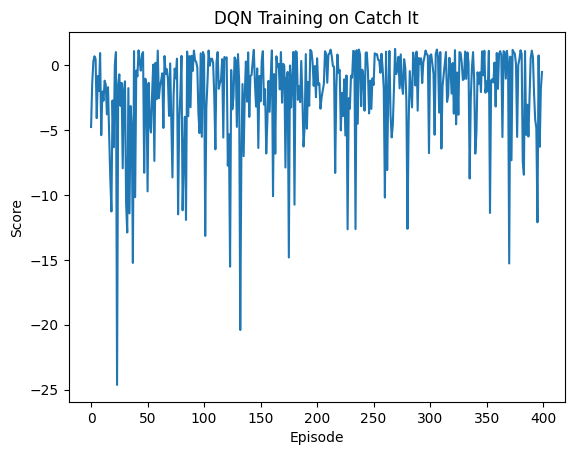

In [24]:
plt.plot(scores)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('DQN Training on Catch It')
plt.show()

In [40]:
torch.save(policy_net, "policy_net.pth")

In [16]:
env = CatchItEnvOneStep()  # Catch It environment
state_size = env.observation_space.shape[0]  
action_size = env.action_space.n    
env.close()
del env

In [8]:
policy_net = DQN(state_size, action_size)  # Main Q-network
policy_net = torch.load("policy_net.pth", weights_only=False)

In [39]:
import pygame
def watch_trained_model(policy_net, episodes=3):
    # Create a new environment with human rendering
    env = CatchItEnvRender(render_mode='human', timer=True)
    
    for episode in range(episodes):
        state, _ = env.reset()
        state = torch.FloatTensor(state)  # Shape [4] (no batch dimension needed)
        total_reward = 0
        
        while True:
            # Get action from trained policy
            with torch.no_grad():
                q_values = policy_net(state)
                action = q_values.argmax().item()
                # print(f"Q-values: {q_values}, Action: {action}")  # Debug print
                # action = select_action(state, 0.05)
            # Take the action and render
            next_state, reward, terminated, truncated, _ = env.step(action)
            env.render()  # Render after taking action
            
            # Small delay to see the movement
            # pygame.time.delay(1)  # 100ms delay
            
            done = terminated or truncated
            next_state = torch.FloatTensor(next_state)
            
            state = next_state
            total_reward += reward
            
            if done:
                print(f"Episode {episode + 1}, Total Reward: {total_reward}, Score: {env.score}")
                break
    
    env.close()

# Run the visualization
watch_trained_model(policy_net, episodes=1)

Episode 1, Total Reward: 843.7347259481264, Score: 38


In [29]:
env.close()